### Assignment 3, Naeim Rashidfarokhi, Data Engineering I 2022

#### Section B - Working with DataFrames and SQL

In [1]:
from pyspark.sql import SparkSession
import pandas as pd

In [2]:
# This boolean is to run the code easier both locally or on server
server_mode = False

In [3]:
if server_mode:
    #New API
    spark_session = SparkSession\
            .builder\
            .master("spark://192.168.2.119:7077") \
            .appName("Naeim_Rashidfarokhi_A3_B")\
            .config("spark.dynamicAllocation.enabled", True)\
            .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
            .config("spark.shuffle.service.enabled", False)\
            .config("spark.dynamicAllocation.executorIdleTimeout","300s")\
            .config("spark.executor.cores",4)\
            .config("spark.driver.port",9998)\
            .config("spark.blockManager.port",10005)\
            .getOrCreate()

    # Old API (RDD)
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")

else:
    # local version, deactivate later!
    spark_session = SparkSession.builder.appName('A3_B').getOrCreate()

22/03/02 10:08:02 WARN Utils: Your hostname, nanook resolves to a loopback address: 127.0.1.1; using 192.168.1.69 instead (on interface enp5s0)
22/03/02 10:08:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/02 10:08:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/02 10:08:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark_session # to get some info about the Session

##### B.1 Load the CSV file from HDFS, and call show() to verify the data is loaded correctly

In [5]:
if server_mode:
    path ="hdfs://host-192-168-2-119-de1:9000/parking-citations.csv"
    df_spark = spark_session.read.csv(path, header=True, inferSchema=True)
else:
    path ="/home/naeim/Desktop/DE1/parking-citations.csv"
    df_spark = spark_session.read.csv(path, header=True, inferSchema=True)

In [6]:
df_spark.show(2)

+-------------+-------------------+----------+--------+-----------+--------------+-----------------+----+----+----------+-----+---------------+-----+------+--------------+---------------------+-----------+--------+---------+------------------+-----------------+----------------------+
|Ticket number|         Issue Date|Issue time|Meter Id|Marked Time|RP State Plate|Plate Expiry Date| VIN|Make|Body Style|Color|       Location|Route|Agency|Violation code|Violation Description|Fine amount|Latitude|Longitude|Agency Description|Color Description|Body Style Description|
+-------------+-------------------+----------+--------+-----------+--------------+-----------------+----+----+----------+-----+---------------+-----+------+--------------+---------------------+-----------+--------+---------+------------------+-----------------+----------------------+
|   1103341116|2015-12-21 00:00:00|    1251.0|    null|       null|            CA|         200304.0|null|HOND|        PA|   GY|13147 WELBY WAY|01

##### B.2 Print the schema for the DataFrame.

In [7]:
# to see column names with their type and ability to accept null
df_spark.printSchema()

root
 |-- Ticket number: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Issue time: double (nullable = true)
 |-- Meter Id: string (nullable = true)
 |-- Marked Time: double (nullable = true)
 |-- RP State Plate: string (nullable = true)
 |-- Plate Expiry Date: double (nullable = true)
 |-- VIN: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- Body Style: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Agency: double (nullable = true)
 |-- Violation code: string (nullable = true)
 |-- Violation Description: string (nullable = true)
 |-- Fine amount: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Agency Description: string (nullable = true)
 |-- Color Description: string (nullable = true)
 |-- Body Style Description: string (nullable = true)



In [8]:
df_spark.dtypes

[('Ticket number', 'string'),
 ('Issue Date', 'timestamp'),
 ('Issue time', 'double'),
 ('Meter Id', 'string'),
 ('Marked Time', 'double'),
 ('RP State Plate', 'string'),
 ('Plate Expiry Date', 'double'),
 ('VIN', 'string'),
 ('Make', 'string'),
 ('Body Style', 'string'),
 ('Color', 'string'),
 ('Location', 'string'),
 ('Route', 'string'),
 ('Agency', 'double'),
 ('Violation code', 'string'),
 ('Violation Description', 'string'),
 ('Fine amount', 'double'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Agency Description', 'string'),
 ('Color Description', 'string'),
 ('Body Style Description', 'string')]

In [9]:
print(f'Number of columns: {len(df_spark.columns)}')

Number of columns: 22


##### B.3 Count the number of rows in the CSV file.

In [10]:
print(f'Number of rows/records: {df_spark.count()}')

Number of rows/records: 13077724


##### B.4 Count the number of partitions in the underlying RDD.

In [11]:
print(f'Number of partitions: {df_spark.rdd.getNumPartitions()}')

Number of partitions: 16


##### B.5 Drop the columns VIN, Latitude and Longitude.

In [12]:
# to drop columns
df_spark = df_spark.drop('VIN', 'Latitude', 'Longitude')
print(f'Number of columns: {len(df_spark.columns)}')

Number of columns: 19


In [13]:
df_spark.dtypes

[('Ticket number', 'string'),
 ('Issue Date', 'timestamp'),
 ('Issue time', 'double'),
 ('Meter Id', 'string'),
 ('Marked Time', 'double'),
 ('RP State Plate', 'string'),
 ('Plate Expiry Date', 'double'),
 ('Make', 'string'),
 ('Body Style', 'string'),
 ('Color', 'string'),
 ('Location', 'string'),
 ('Route', 'string'),
 ('Agency', 'double'),
 ('Violation code', 'string'),
 ('Violation Description', 'string'),
 ('Fine amount', 'double'),
 ('Agency Description', 'string'),
 ('Color Description', 'string'),
 ('Body Style Description', 'string')]

##### B.6 Find the maximum fine amount. How many fines have this amount? You need to convert the ‘fine amount’ column to a float to do this correctly.

In [14]:
# The 'Fine amount' is already of type double because of 
# inferSchema=True in read.csv() function but if it was not
from pyspark.sql.types import FloatType
df_spark = df_spark.withColumn('Fine amount', 
                    df_spark['Fine amount'].cast(FloatType()))

In [15]:
# Simply to see the maximum fine amonut we can call describe()
df_spark.select(['Fine amount']).describe().show()

+-------+------------------+
|summary|       Fine amount|
+-------+------------------+
|  count|          13004253|
|   mean| 70.97387592582184|
| stddev|35.374219701867794|
|    min|               1.0|
|    max|            1100.0|
+-------+------------------+



In [16]:
# Or we can find the max amount by aggregation
df_spark.agg({"Fine amount":"max"}).show()

+----------------+
|max(Fine amount)|
+----------------+
|          1100.0|
+----------------+



In [17]:
# For the counts as well
from pyspark.sql.functions import col
df_spark.select(['Fine amount']).groupBy("Fine amount") \
        .count().sort(col("Fine amount").desc()).show(5)

+-----------+-----+
|Fine amount|count|
+-----------+-----+
|     1100.0|  626|
|     1000.0| 1672|
|      505.0|    6|
|      500.0| 1973|
|      363.0|87596|
+-----------+-----+
only showing top 5 rows



##### B.7 Show the top 20 most frequent vehicle makes, and their frequencies.

In [18]:
df_spark.select(['Make']).groupBy("Make") \
        .count().sort(col("count").desc()).show(20)

+----+-------+
|Make|  count|
+----+-------+
|TOYT|2150768|
|HOND|1479996|
|FORD|1116235|
|NISS| 945133|
|CHEV| 892676|
| BMW| 603092|
|MERZ| 543298|
|VOLK| 432030|
|HYUN| 404917|
|DODG| 391686|
|LEXS| 368420|
| KIA| 328155|
|JEEP| 316300|
|AUDI| 255395|
|MAZD| 242344|
|OTHR| 205546|
| GMC| 184889|
|INFI| 174315|
|CHRY| 159948|
|SUBA| 154640|
+----+-------+
only showing top 20 rows



##### B.8 Let’s expand some abbreviations in the color column. Create a User Defined Function to create a new column, ‘color long’, mapping the original colors to their corresponding values in the dictionary below. If there is no key matching the original color, use the original color.

In [19]:
COLORS = {
'AL':'Aluminum', 'AM':'Amber', 'BG':'Beige', 'BK':'Black',
'BL':'Blue', 'BN':'Brown', 'BR':'Brown', 'BZ':'Bronze',
'CH':'Charcoal', 'DK':'Dark', 'GD':'Gold', 'GO':'Gold',
'GN':'Green', 'GY':'Gray', 'GT':'Granite', 'IV':'Ivory',
'LT':'Light', 'OL':'Olive', 'OR':'Orange', 'MR':'Maroon',
'PK':'Pink', 'RD':'Red', 'RE':'Red', 'SI':'Silver', 'SL':'Silver',
'SM':'Smoke', 'TN':'Tan', 'VT':'Violet', 'WT':'White', 'WH':'White',
'YL':'Yellow', 'YE':'Yellow', 'UN':'Unknown'
}

In [20]:
# To get insight from missing, null values from 'Color' column
df_spark.filter(df_spark.Color.isNull()).count()

35337

In [21]:
# Replace missing, null values with 'Unknown'
df_spark = df_spark.na.fill('UN')
df_spark.filter(df_spark.Color.isNull()).count()

0

In [22]:
# a User Defined Function can be used in WithColumn()
from pyspark.sql.functions import udf

def full_color(any_color, color_dict):
    default_value = any_color
    return color_dict.get(any_color, default_value)

my_udf = udf(lambda x: full_color(x, COLORS))

In [23]:
# To add the new column
df_spark = df_spark.withColumn('color long', \
                        my_udf(df_spark['Color']))
df_spark.select(['Color', 'color long']).show(10)

+-----+----------+
|Color|color long|
+-----+----------+
|   GY|      Gray|
|   WH|     White|
|   BK|     Black|
|   WH|     White|
|   BK|     Black|
|   GY|      Gray|
|   BL|      Blue|
|   BK|     Black|
|   BR|     Brown|
|   SI|    Silver|
+-----+----------+
only showing top 10 rows



##### B.9 Using this new column, what’s the most frequent colour value for Toyotas (TOYT)?

In [24]:
toyota_colors = df_spark.groupBy('Make', 'color long') \
                        .count().sort(col("count").desc()) \
                        .filter(df_spark['Make'] == 'TOYT')
toyota_colors.show(20)

+----+----------+------+
|Make|color long| count|
+----+----------+------+
|TOYT|      Gray|489697|
|TOYT|     White|434595|
|TOYT|     Black|353812|
|TOYT|    Silver|347894|
|TOYT|      Blue|180091|
|TOYT|       Red|119074|
|TOYT|     Green| 74968|
|TOYT|      Gold| 40646|
|TOYT|    Maroon| 26242|
|TOYT|       Tan| 23355|
|TOYT|     Beige| 15723|
|TOYT|        OT| 15719|
|TOYT|     Brown| 11454|
|TOYT|    Yellow|  4372|
|TOYT|        PR|  4272|
|TOYT|    Orange|  3575|
|TOYT|   Unknown|  2783|
|TOYT|        TU|  1647|
|TOYT|        CO|   730|
|TOYT|      Pink|   117|
+----+----------+------+
only showing top 20 rows



In [25]:
# Prepration for a barplot
toyota_colors = toyota_colors.collect()
counts = [x['count'] for x in toyota_colors]
colors = [x['color long'] for x in toyota_colors]

In [26]:
import matplotlib.colors as mcolors
color_for_bars = []
for color in colors:
    if color.lower() in mcolors.CSS4_COLORS:
        color_for_bars.append(color)
    else:
        color_for_bars.append('White')

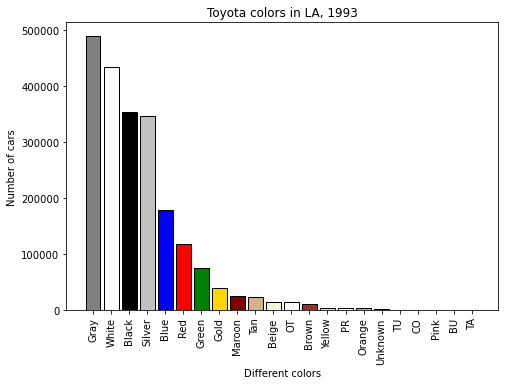

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(colors, counts, color=color_for_bars, edgecolor='Black')
    
plt.title("Toyota colors in LA, 1993")
plt.xlabel("Different colors")
plt.ylabel("Number of cars")
plt.xticks(rotation='vertical')
plt.show()

In [29]:
# To stop the underlying SparkContext
spark_session.stop()
print("Done!")

Done!
